In [204]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [205]:
stats = pd.read_csv('stats.csv')
stats.head()

,date,business,category,item_description,document,document_ID,client_name,packaging,unit_cost,sold_quantity,...,current_balance,amount_paid,payment_dates,gross_profit_percentage,address,client_ID,item_ID,year_extracted,month_extracted,day_extracted
0,2020-01-02,Industrial,Tapas,Tapa_BU32_28mm_Verde,Factura,5100,Corporación DRC S.A.,4150,47.67000,2.0,...,0.0,167.990,2020-02-19 00:00:00,0.392739,Las Cumbres,389,55,2020,1,2
1,2020-01-02,Lubricantes,Lubricantes,Aceite_25W60,Factura,5101,Indigo Truck and Parts S.A.,1,6.70000,15.0,...,0.0,154.080,2020-01-02 00:00:00,0.302083,Chilibre Panama,813,9,2020,1,2
2,2020-01-02,Industrial,Gorro/Mascarilla,Mascarilla,Factura,5102,Agua Mundo,50,1.95000,1.0,...,0.0,5.885,2020-03-06 00:00:00,0.645455,NaN,51,46,2020,1,2
3,2020-01-02,Industrial,Tapas,Tapas_Garrafon,Factura,5102,Agua Mundo,500,29.28000,2.0,...,0.0,149.800,2020-03-06 00:00:00,0.581714,NaN,51,64,2020,1,2
4,2020-01-03,Lubricantes,Lubricantes,Aceite_85W140_5gl,Factura,5103,Transportes Daniel e hijos S.A.,5gls,41.89488,3.0,...,0.0,219.885,2020-03-03 00:00:00,0.388396,Tocumen,1731,12,2020,1,3


In [206]:
stats_2020 = stats.loc[stats["year_extracted"] == 2020]
stats_2021 = stats.loc[stats["year_extracted"] == 2021]
stats_2022 = stats.loc[stats["year_extracted"] == 2022]
stats_2023 = stats.loc[stats["year_extracted"] == 2023]
stats_2024 = stats.loc[stats["year_extracted"] == 2024]

In [207]:
def items_sold(a, b, c, d, e):

    unique_a = a['item_ID'].nunique()
    unique_b = b['item_ID'].nunique()
    unique_c = c['item_ID'].nunique()
    unique_d = d['item_ID'].nunique()
    unique_e = e['item_ID'].nunique()

    print("We sold a total of different products for 2020: ", unique_a, "For 2021: ", unique_b, "For 2022: ", unique_c, "For 2023: ", unique_d, "For 2024: ", unique_e)

def client_sold(a, b, c, d, e):

    unique_a = a['client_ID'].nunique()
    unique_b = b['client_ID'].nunique()
    unique_c = c['client_ID'].nunique()
    unique_d = d['client_ID'].nunique()
    unique_e = e['client_ID'].nunique()

    print("We have a total of different clients for 2020: ", unique_a, "For 2021: ", unique_b, "For 2022: ", unique_c, "For 2023: ", unique_d, "For 2024: ", unique_e)

def time_series_plot_item(df):
    
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)
    


    for group_name, group_data in df.groupby('item_description'):
        plt.figure(figsize=(8, 3))
        plt.plot(group_data.index, group_data['sold_quantity'], linestyle='dotted', label=f'ID {group_name}')
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Time Series Plot for ID {group_name}')
        plt.xlabel('Date')
        plt.ylabel('Sold Quantity')
        plt.legend()
        plt.grid(True)
        plt.show()



In [208]:
items_sold(stats_2020, stats_2021, stats_2022, stats_2023, stats_2024)

client_sold(stats_2020, stats_2021, stats_2022, stats_2023, stats_2024)

We sold a total of different products for 2020:  55 For 2021:  54 For 2022:  52 For 2023:  50 For 2024:  33
We have a total of different clients for 2020:  898 For 2021:  640 For 2022:  489 For 2023:  707 For 2024:  51


In [209]:
stats_2020_l = stats_2020.loc[stats_2020["category"] == "Lubricantes"]
stats_2020_t = stats_2020.loc[stats_2020["category"] == "Tapas"]
stats_2020_g = stats_2020.loc[stats_2020["category"] == "Gorro/Mascarilla"]
stats_2020_f = stats_2020.loc[stats_2020["category"] == "Frascos"]

#array(['Tapas', 'Lubricantes', 'Gorro/Mascarilla', 'Frascos', 'Anulación',
#       'Alquiler', 'Pets', 'Despacho'], dtype=object

C:\Users\andre\AppData\Local\Temp\ipykernel_22844\3853983927.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"])


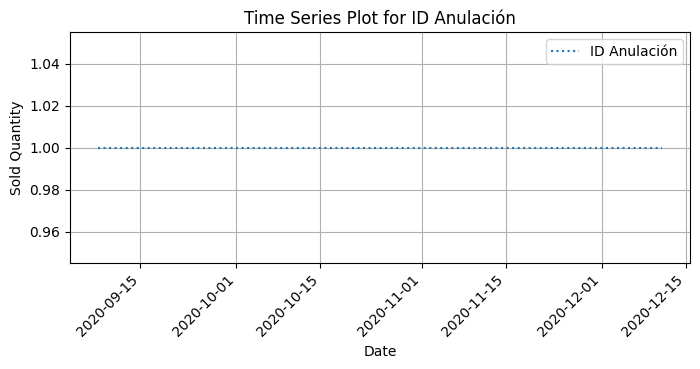

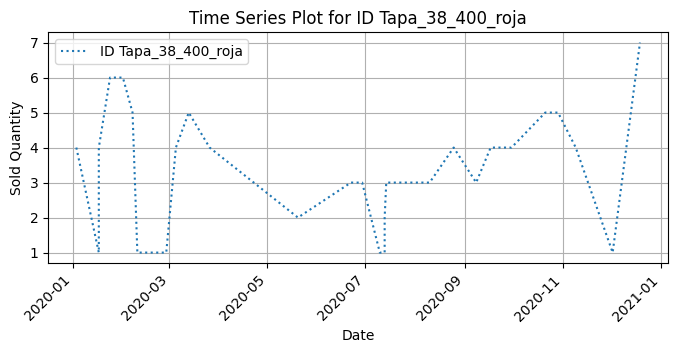

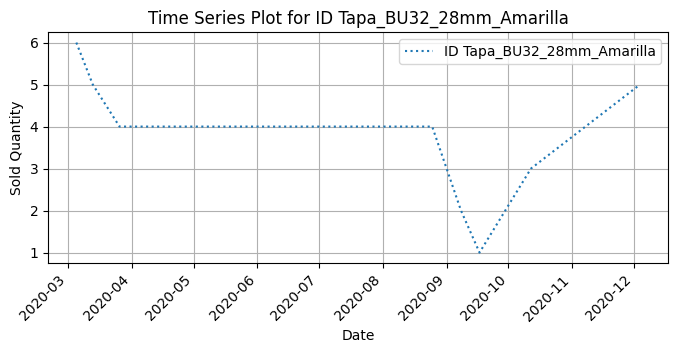

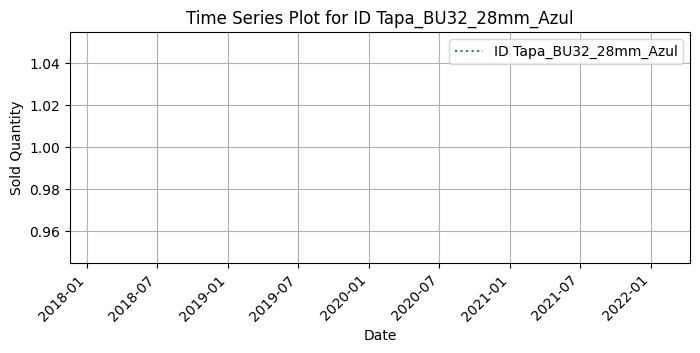

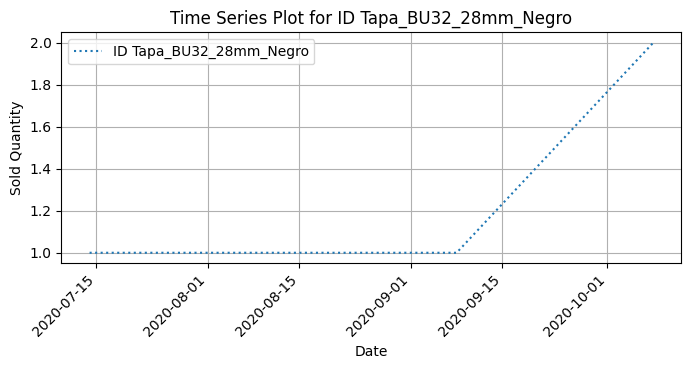

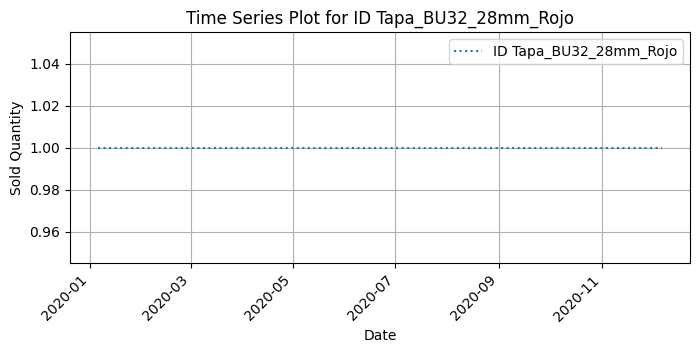

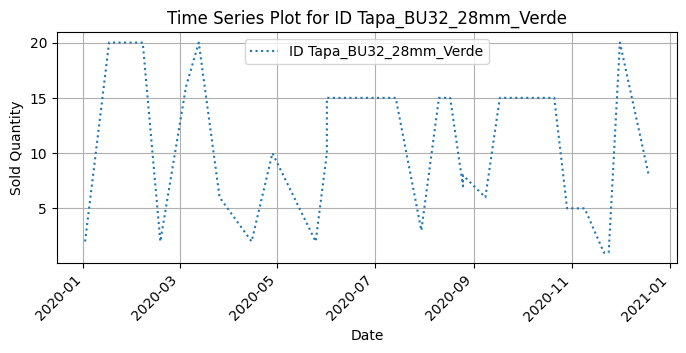

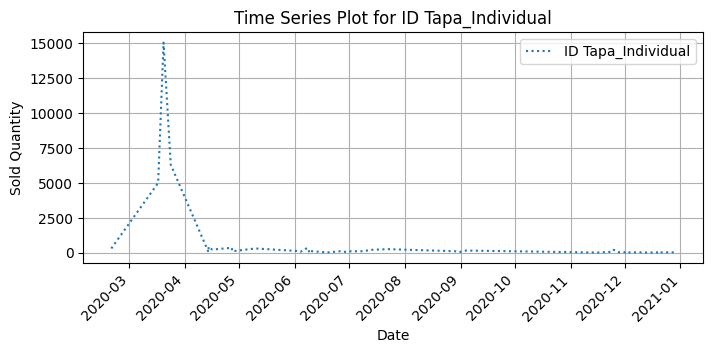

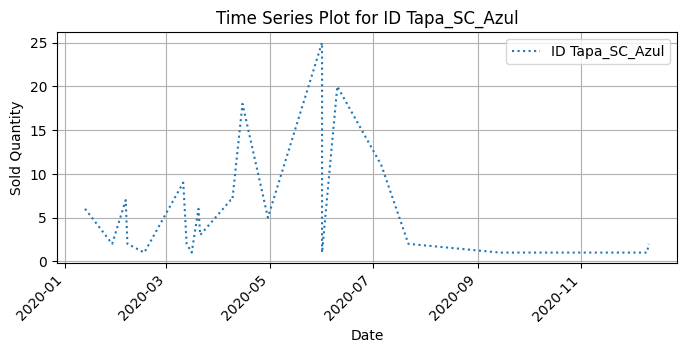

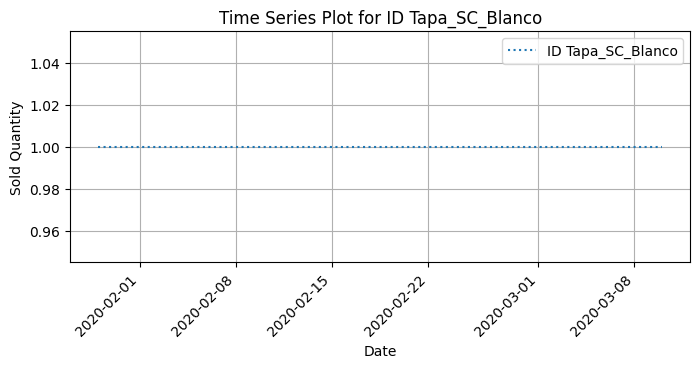

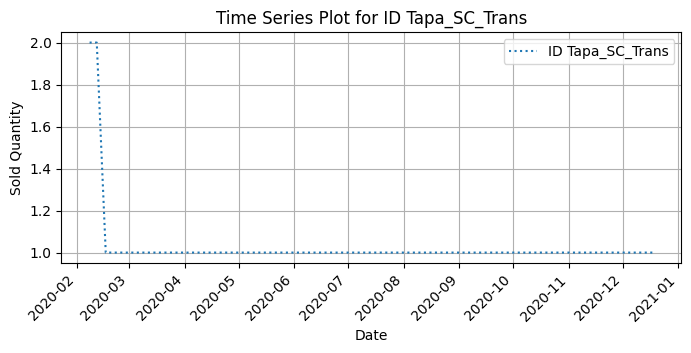

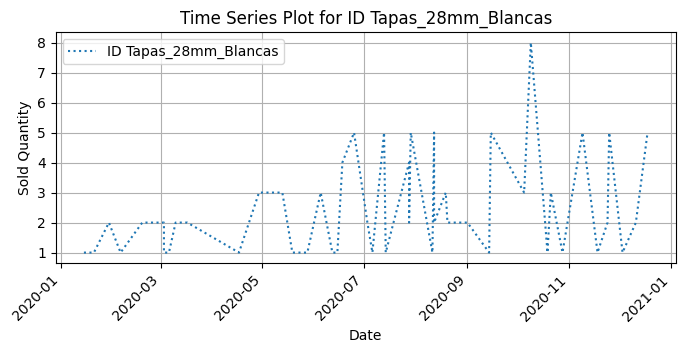

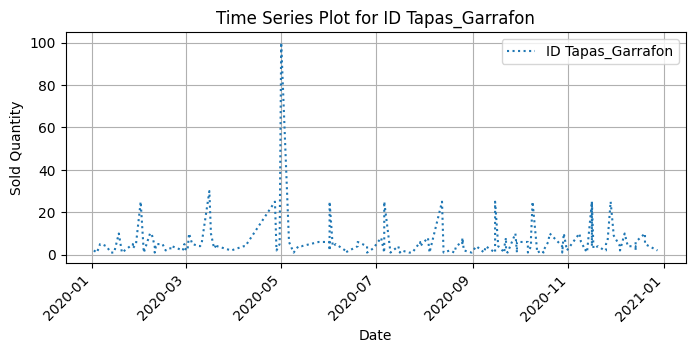

In [210]:
time_series_plot_item(stats_2020_t)

C:\Users\andre\AppData\Local\Temp\ipykernel_22844\3853983927.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"])


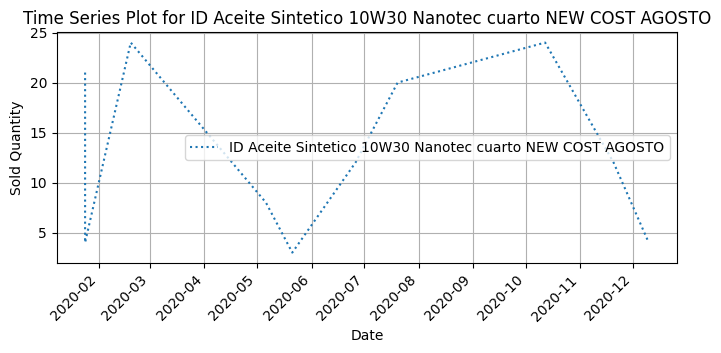

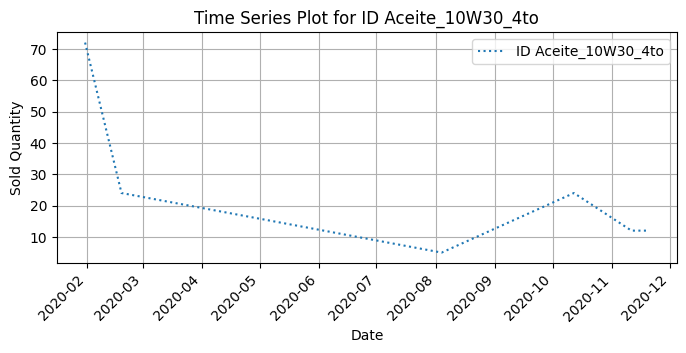

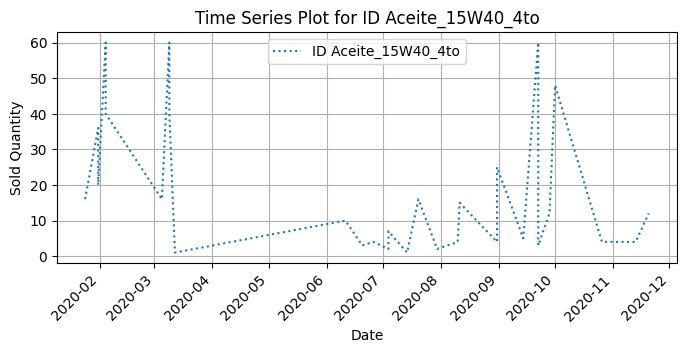

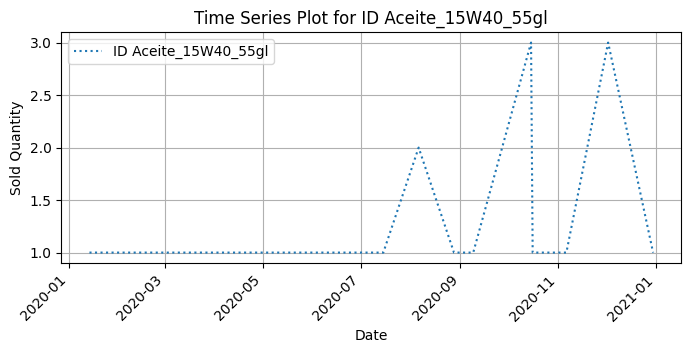

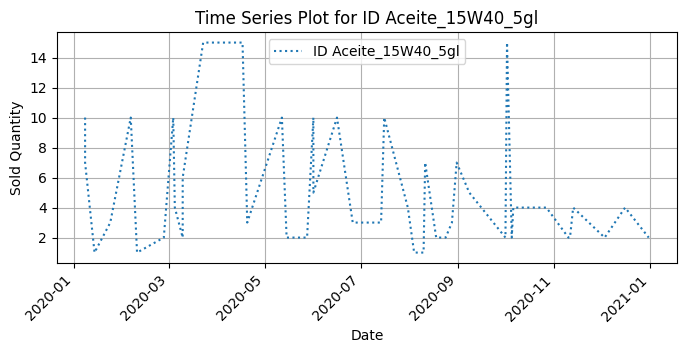

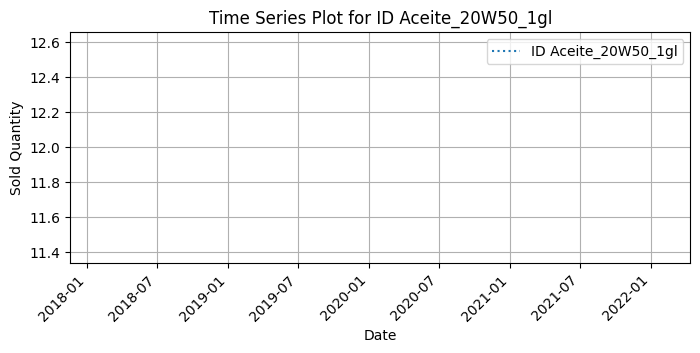

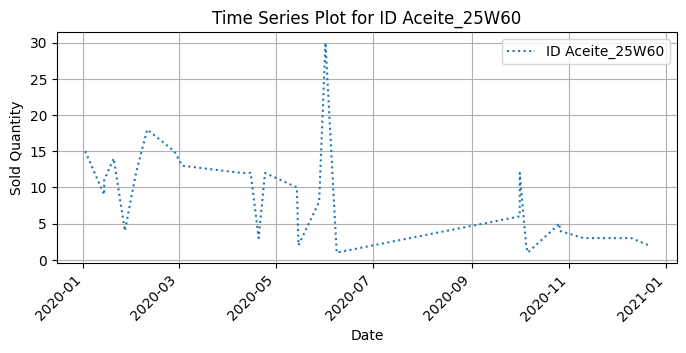

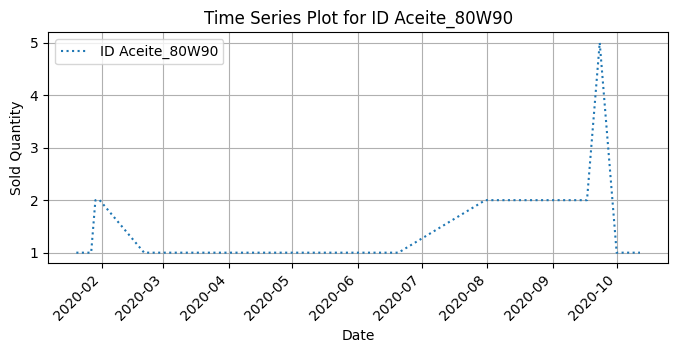

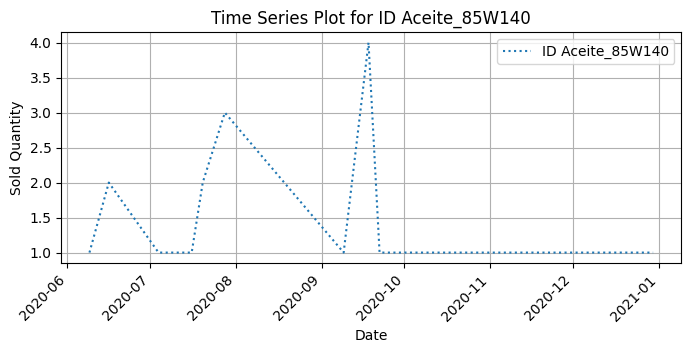

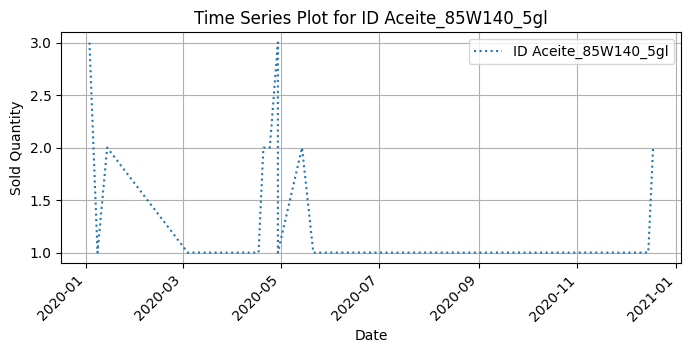

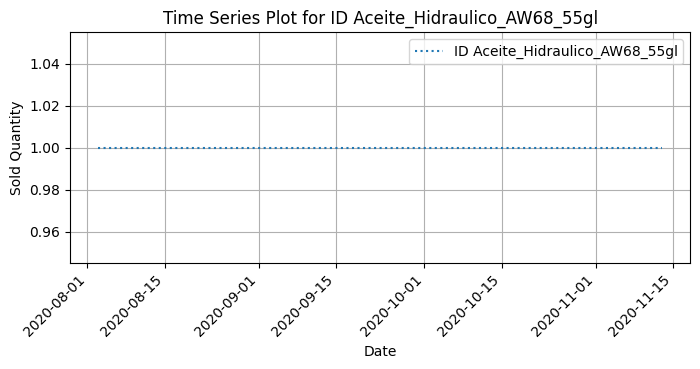

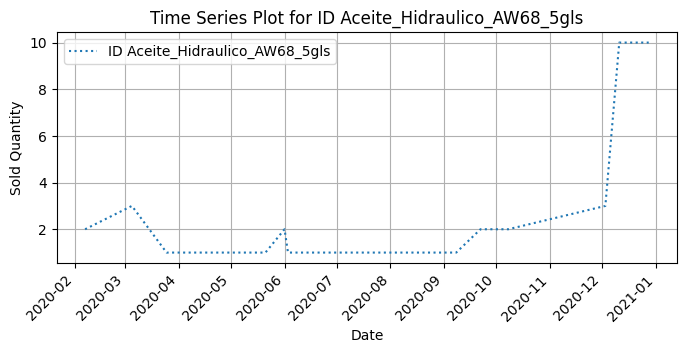

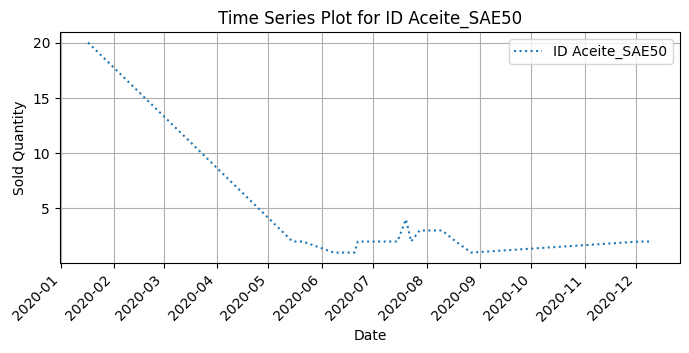

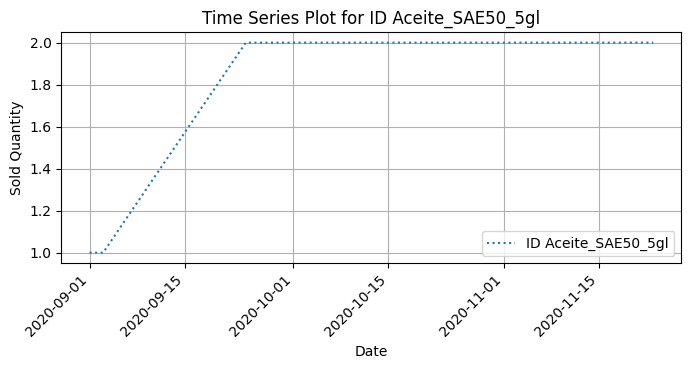

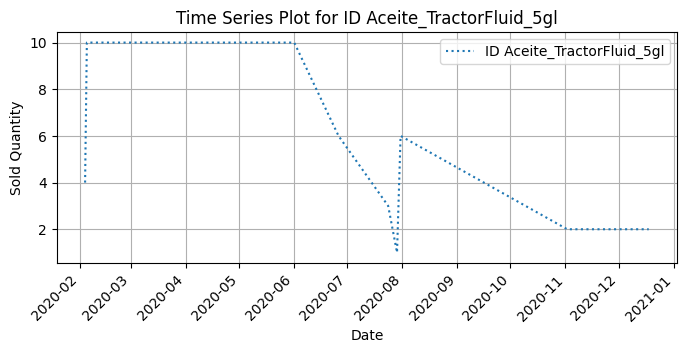

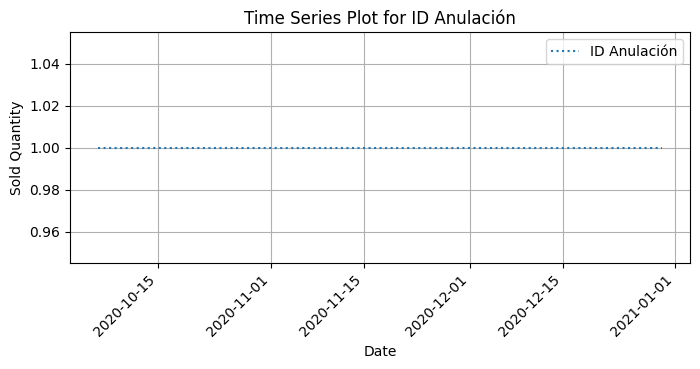

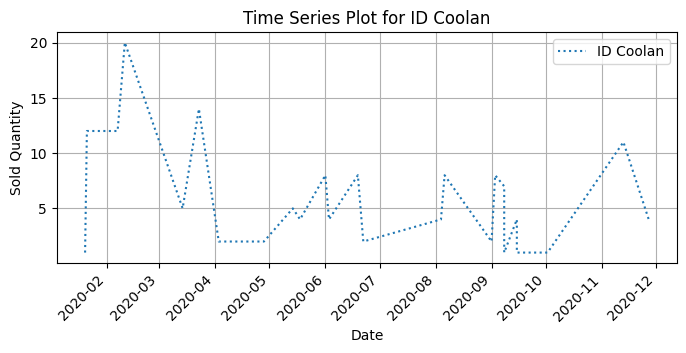

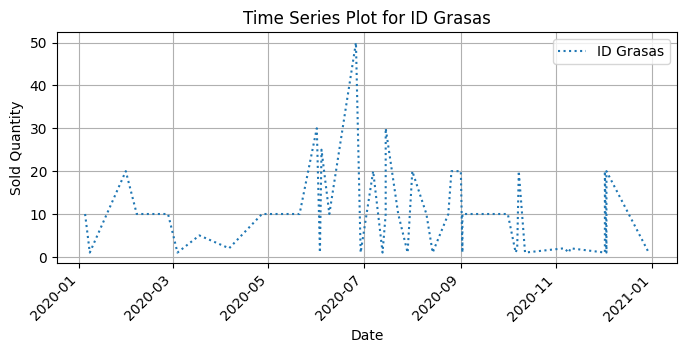

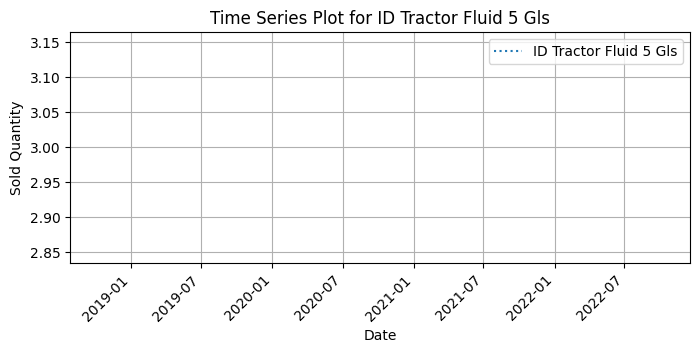

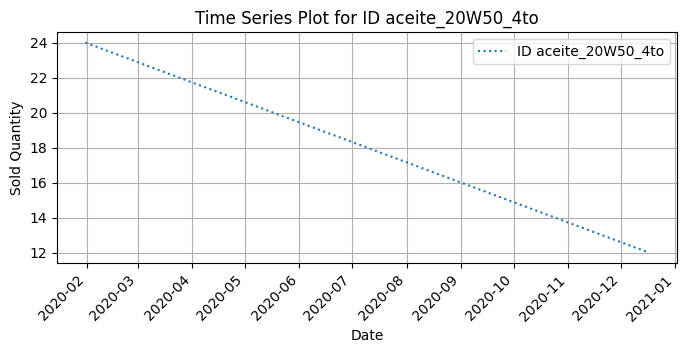

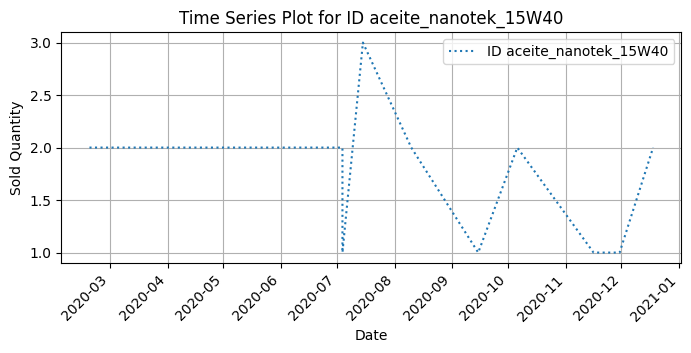

In [211]:
time_series_plot_item(stats_2020_l)

C:\Users\andre\AppData\Local\Temp\ipykernel_22844\3853983927.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"])


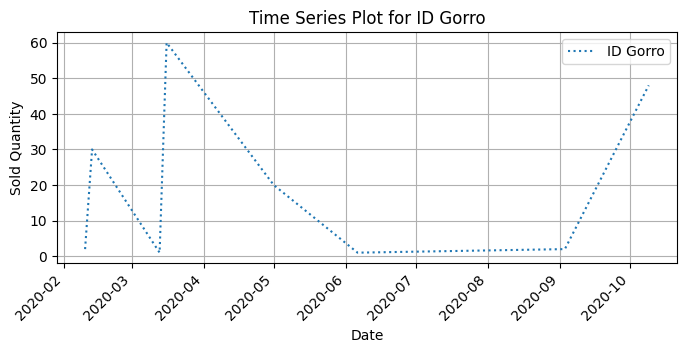

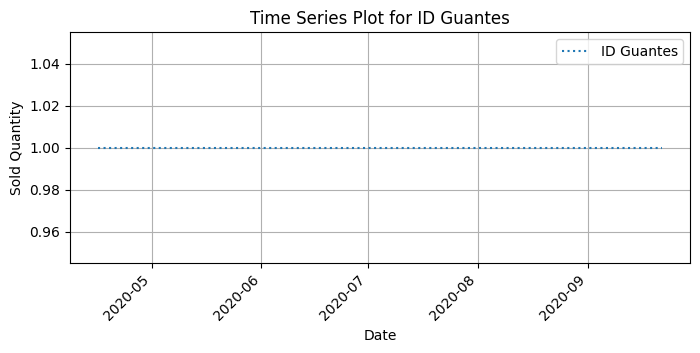

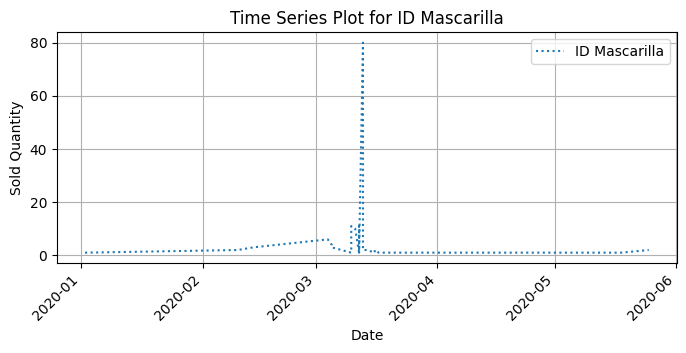

In [212]:
time_series_plot_item(stats_2020_g)

C:\Users\andre\AppData\Local\Temp\ipykernel_22844\3853983927.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"])


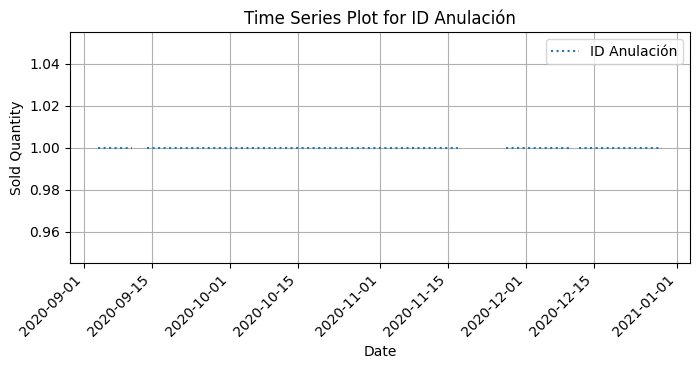

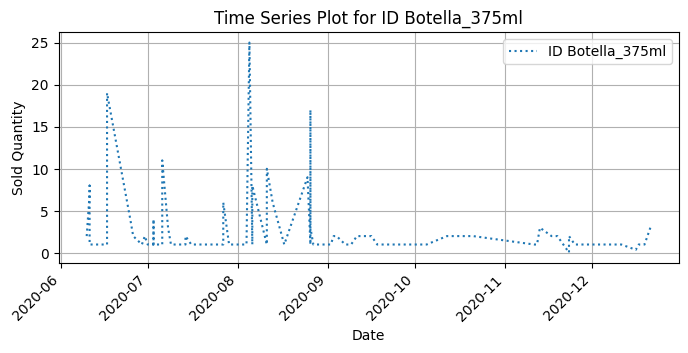

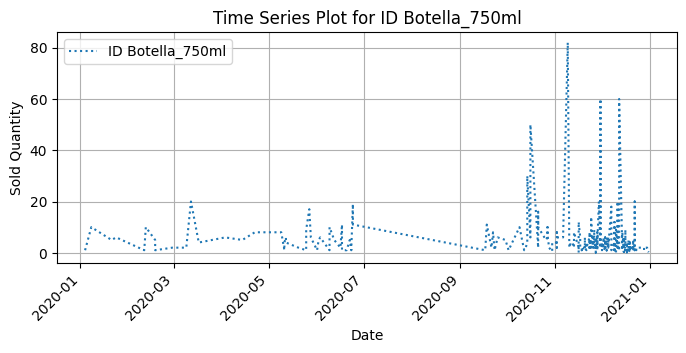

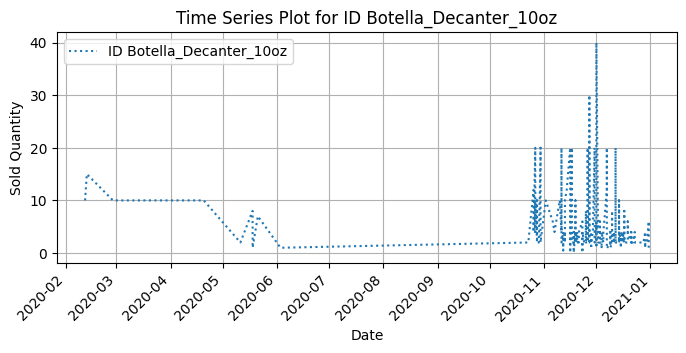

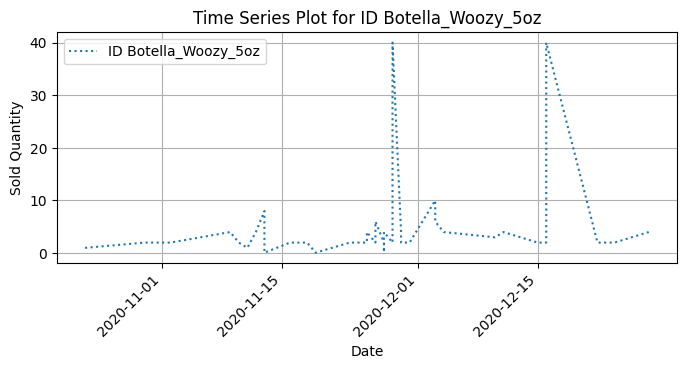

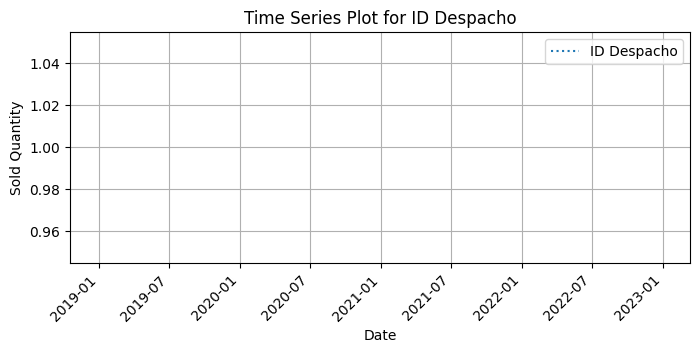

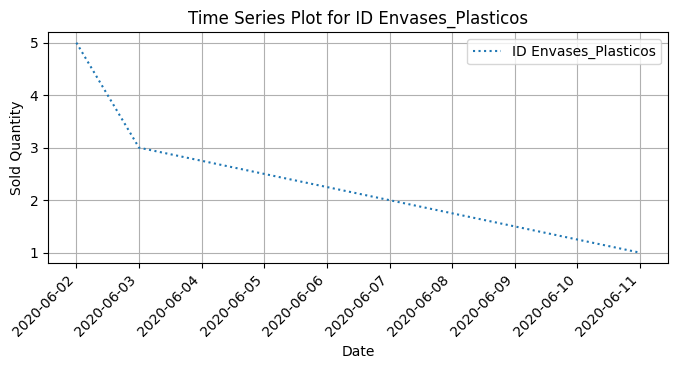

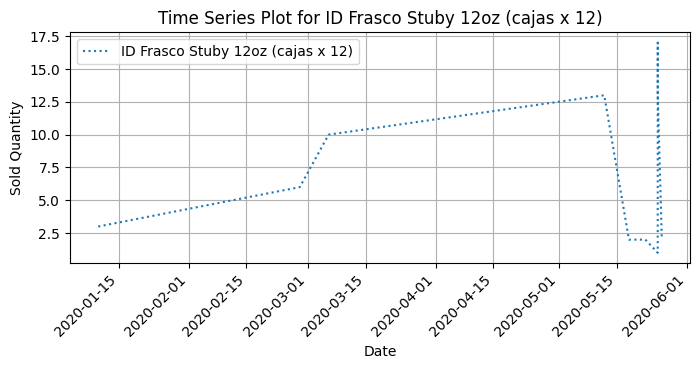

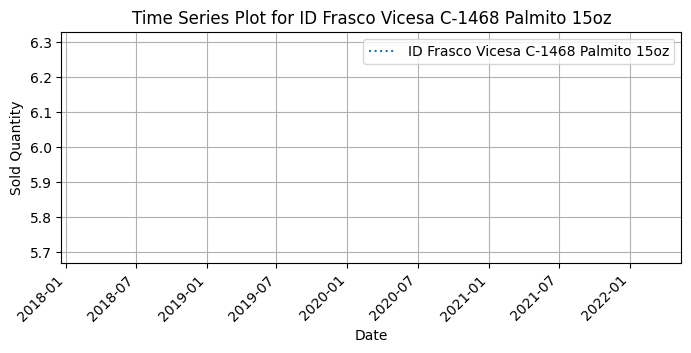

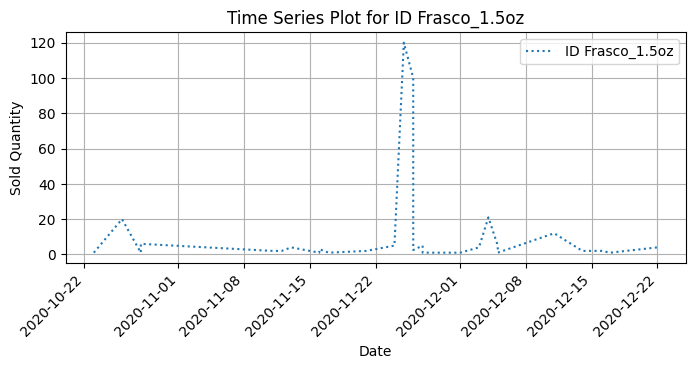

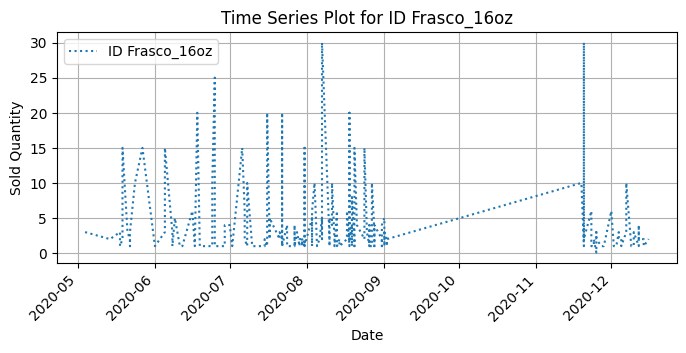

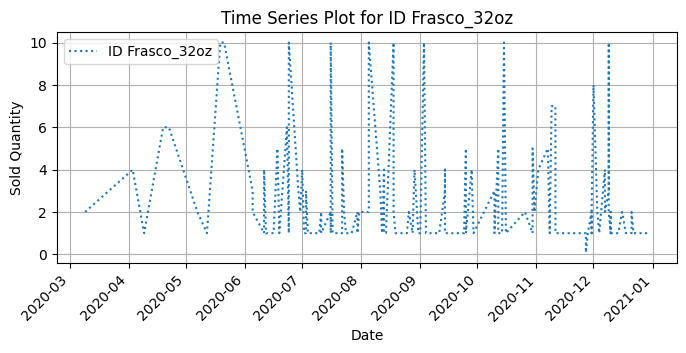

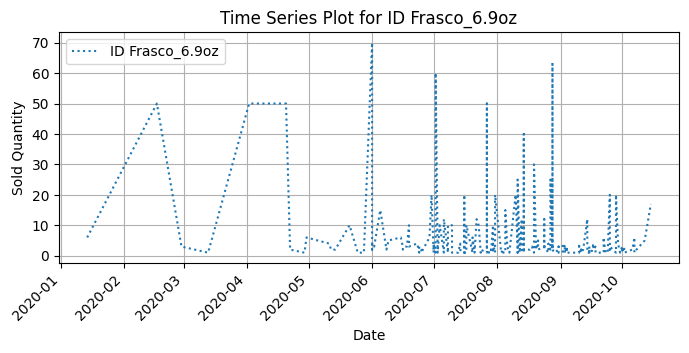

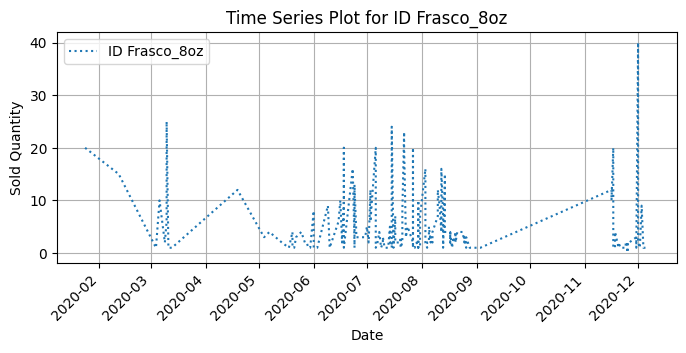

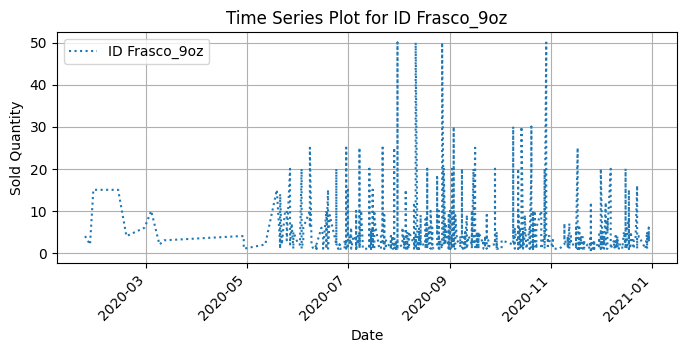

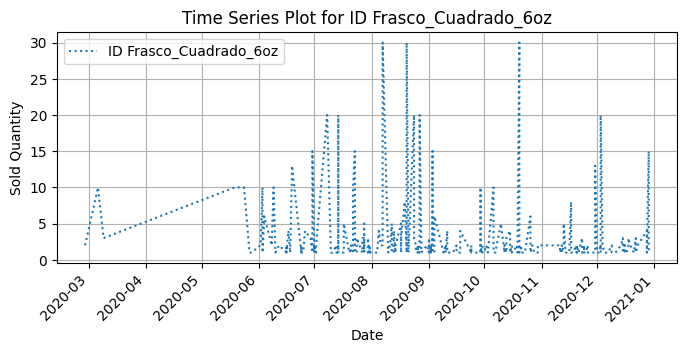

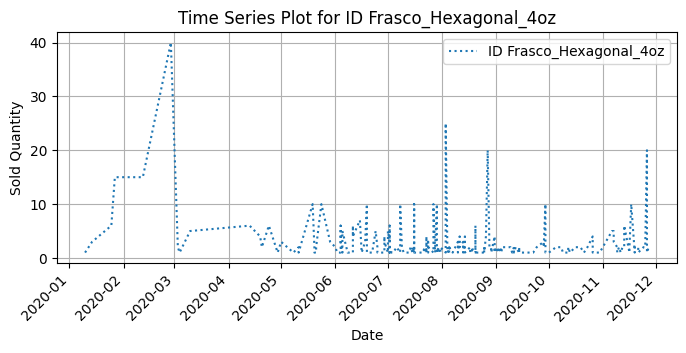

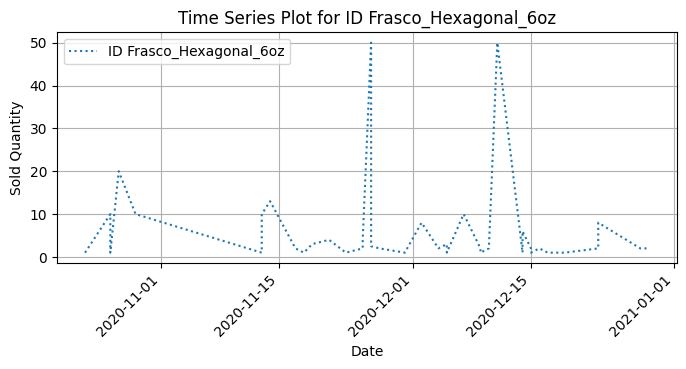

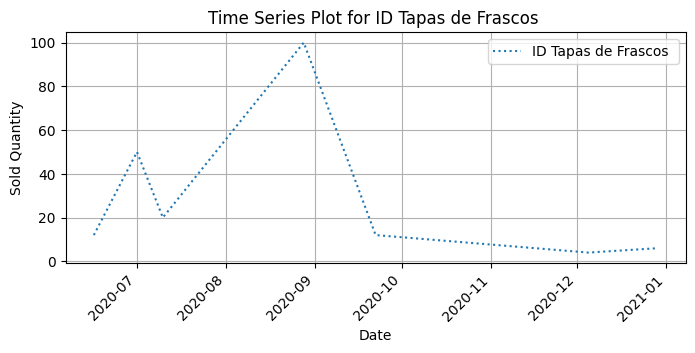

In [213]:
time_series_plot_item(stats_2020_f)